# PlantPal-PFE
## Diagnostique de maladie de plante
Ce projet à pour but de pouvoir diagnostiquer une maladie d'une certaine plante en recevant uniquement une image comme entrée, à l'aide de réseaux de neuronnes convolutifs

Les models utilisés pour le projets seront préentraînés puis fine-tuned avec nos données de plante, afin de maximiser la performance de notre model

Pour le données utilisé dans ce projet, nous avons décidés d'utiliser le dataset `plant_village`(https://www.tensorflow.org/datasets/catalog/plant_village?hl=fr), puisqu'il est suffisamment large pour être pertinent, puis assez documenté pour garantir une utilisation simple 

# Modules et bibliotèques python

### Import de bibliotèques

In [1]:
#General
import os
from prettytable import PrettyTable # package for printing easily tables

#Math
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
from collections import Counter # dict subclass for counting hashable objects
from scipy import stats # package for statistical functions

#AI
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # package for metrics, used for confusion matrix
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import utils
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAvgPool2D, GlobalAveragePooling2D, Activation, BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image
import cv2

In [2]:
print("TensorFlow Version: ", tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    

TensorFlow Version:  2.10.0
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


# 1 - Analyse des données


## Charger le fichier de données

Statistiques des données

#### Code

In [4]:
IMG_SIZE = 128  # Size necessary for VGG19
DATADIR = '../../data'  # replace with your actual path

CATEGORIES = [folder for folder in os.listdir(DATADIR)] 
print(CATEGORIES)

dataset = []
X = []
Y = []

for category in CATEGORIES:
    print("Analysing " + category + "...")
    category_path = os.path.join(DATADIR, category)  # path to disease or healthy dir
    class_num = CATEGORIES.index(category)  # get the classification  (0 to 9)
    for plant_folder in os.listdir(category_path):
        plant_path = os.path.join(category_path, plant_folder)
        for img in os.listdir(plant_path):
            try:
                img_array = cv2.imread(os.path.join(plant_path, img))  # read the image
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
                dataset.append([img_resized, class_num])  # add it to the dataset. Not adding it to X and Y yet because we need to shuffle the dataset
            except Exception as e:
                print(e)
                pass


['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Powdery_mildew', 'Rust', 'Spider_mites', 'Target_Spot']
Analysing Bacterial_spot...
Analysing Early_blight...
Analysing Healthy...
Analysing Late_blight...
Analysing Leaf_Mold...
Analysing Mosaic_virus...
Analysing Powdery_mildew...
Analysing Rust...
Analysing Spider_mites...
Analysing Target_Spot...


# 2 - Préparation des données

#### Description
Normalisation des données et séparations des données en ensemble d'entraînement, de validation et de test. 

#### Code

In [4]:
#Shuffling data
np.random.shuffle(dataset)

# Split into features (X) and labels (Y)
for features, label in dataset:
    X.append(features)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# Normalize X
#X = X / 255.0

# Split into train, valid and test, with a ratio of 70-15-15. Can be adapted later.
print("Splitting data...")
X_train = X[:int(len(X)*.7)]
Y_train = Y[:int(len(X)*.7)]
X_temp = X[int(len(X)*.7):]
Y_temp = Y[int(len(X)*.7):]

X_val = X_temp[:int(len(X_temp)*.5)]
Y_val = Y_temp[:int(len(X_temp)*.5)]
X_test = X_temp[int(len(X_temp)*.5):]
Y_test = Y_temp[int(len(X_temp)*.5):]

# Print the shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))

Splitting data...
X_train shape: (14439, 128, 128, 3)
X_test shape: (3095, 128, 128, 3)
X_val shape: (3094, 128, 128, 3)


### Pré-traitement des images


Prétraitement consistant d'un nettoyage des données en retirants les outliers, selon un z_score et un threshold donnée.

#### Code

In [23]:

def cleanZScore(data, ydata, threshold=1.65, removePercent=0.01):
    # Remove outliers from the dataset using z-score.
    z_scores = stats.zscore(data)
    outliers = np.where(np.abs(z_scores) > threshold)
    toRemoveIndex = []
    b = Counter(outliers[0])
    # Enleve un nombre `numDel` d'image.
    numDel = int(len(data) * removePercent)
    toRemove = b.most_common(numDel)
    for j in range(0,len(toRemove)):
           toRemoveIndex.append(toRemove[j][0])
    for i in toRemoveIndex:
       data = np.delete(data, i, axis=0)
       ydata = np.delete(ydata, i, axis=0)
    return data

#Removing outliers from the dataset using z-score.
print("Cleaning Training data ...")
cleanZScore(X_train, Y_train)
print("Cleaning Test data ...")
cleanZScore(X_test, Y_test)
print("Cleaning Validation data ...")
cleanZScore(X_val, Y_val)


MemoryError: Unable to allocate 5.29 GiB for an array with shape (14437, 128, 128, 3) and data type float64

### One-hot encode labels

Pour notre réseau de neurone, nous aurons besoin des étiquettes en mode one-hot encoded

In [6]:
ytrain = utils.to_categorical(Y_train)
yval   = utils.to_categorical(Y_val)
ytest  = utils.to_categorical(Y_test)

## Visualisation Data

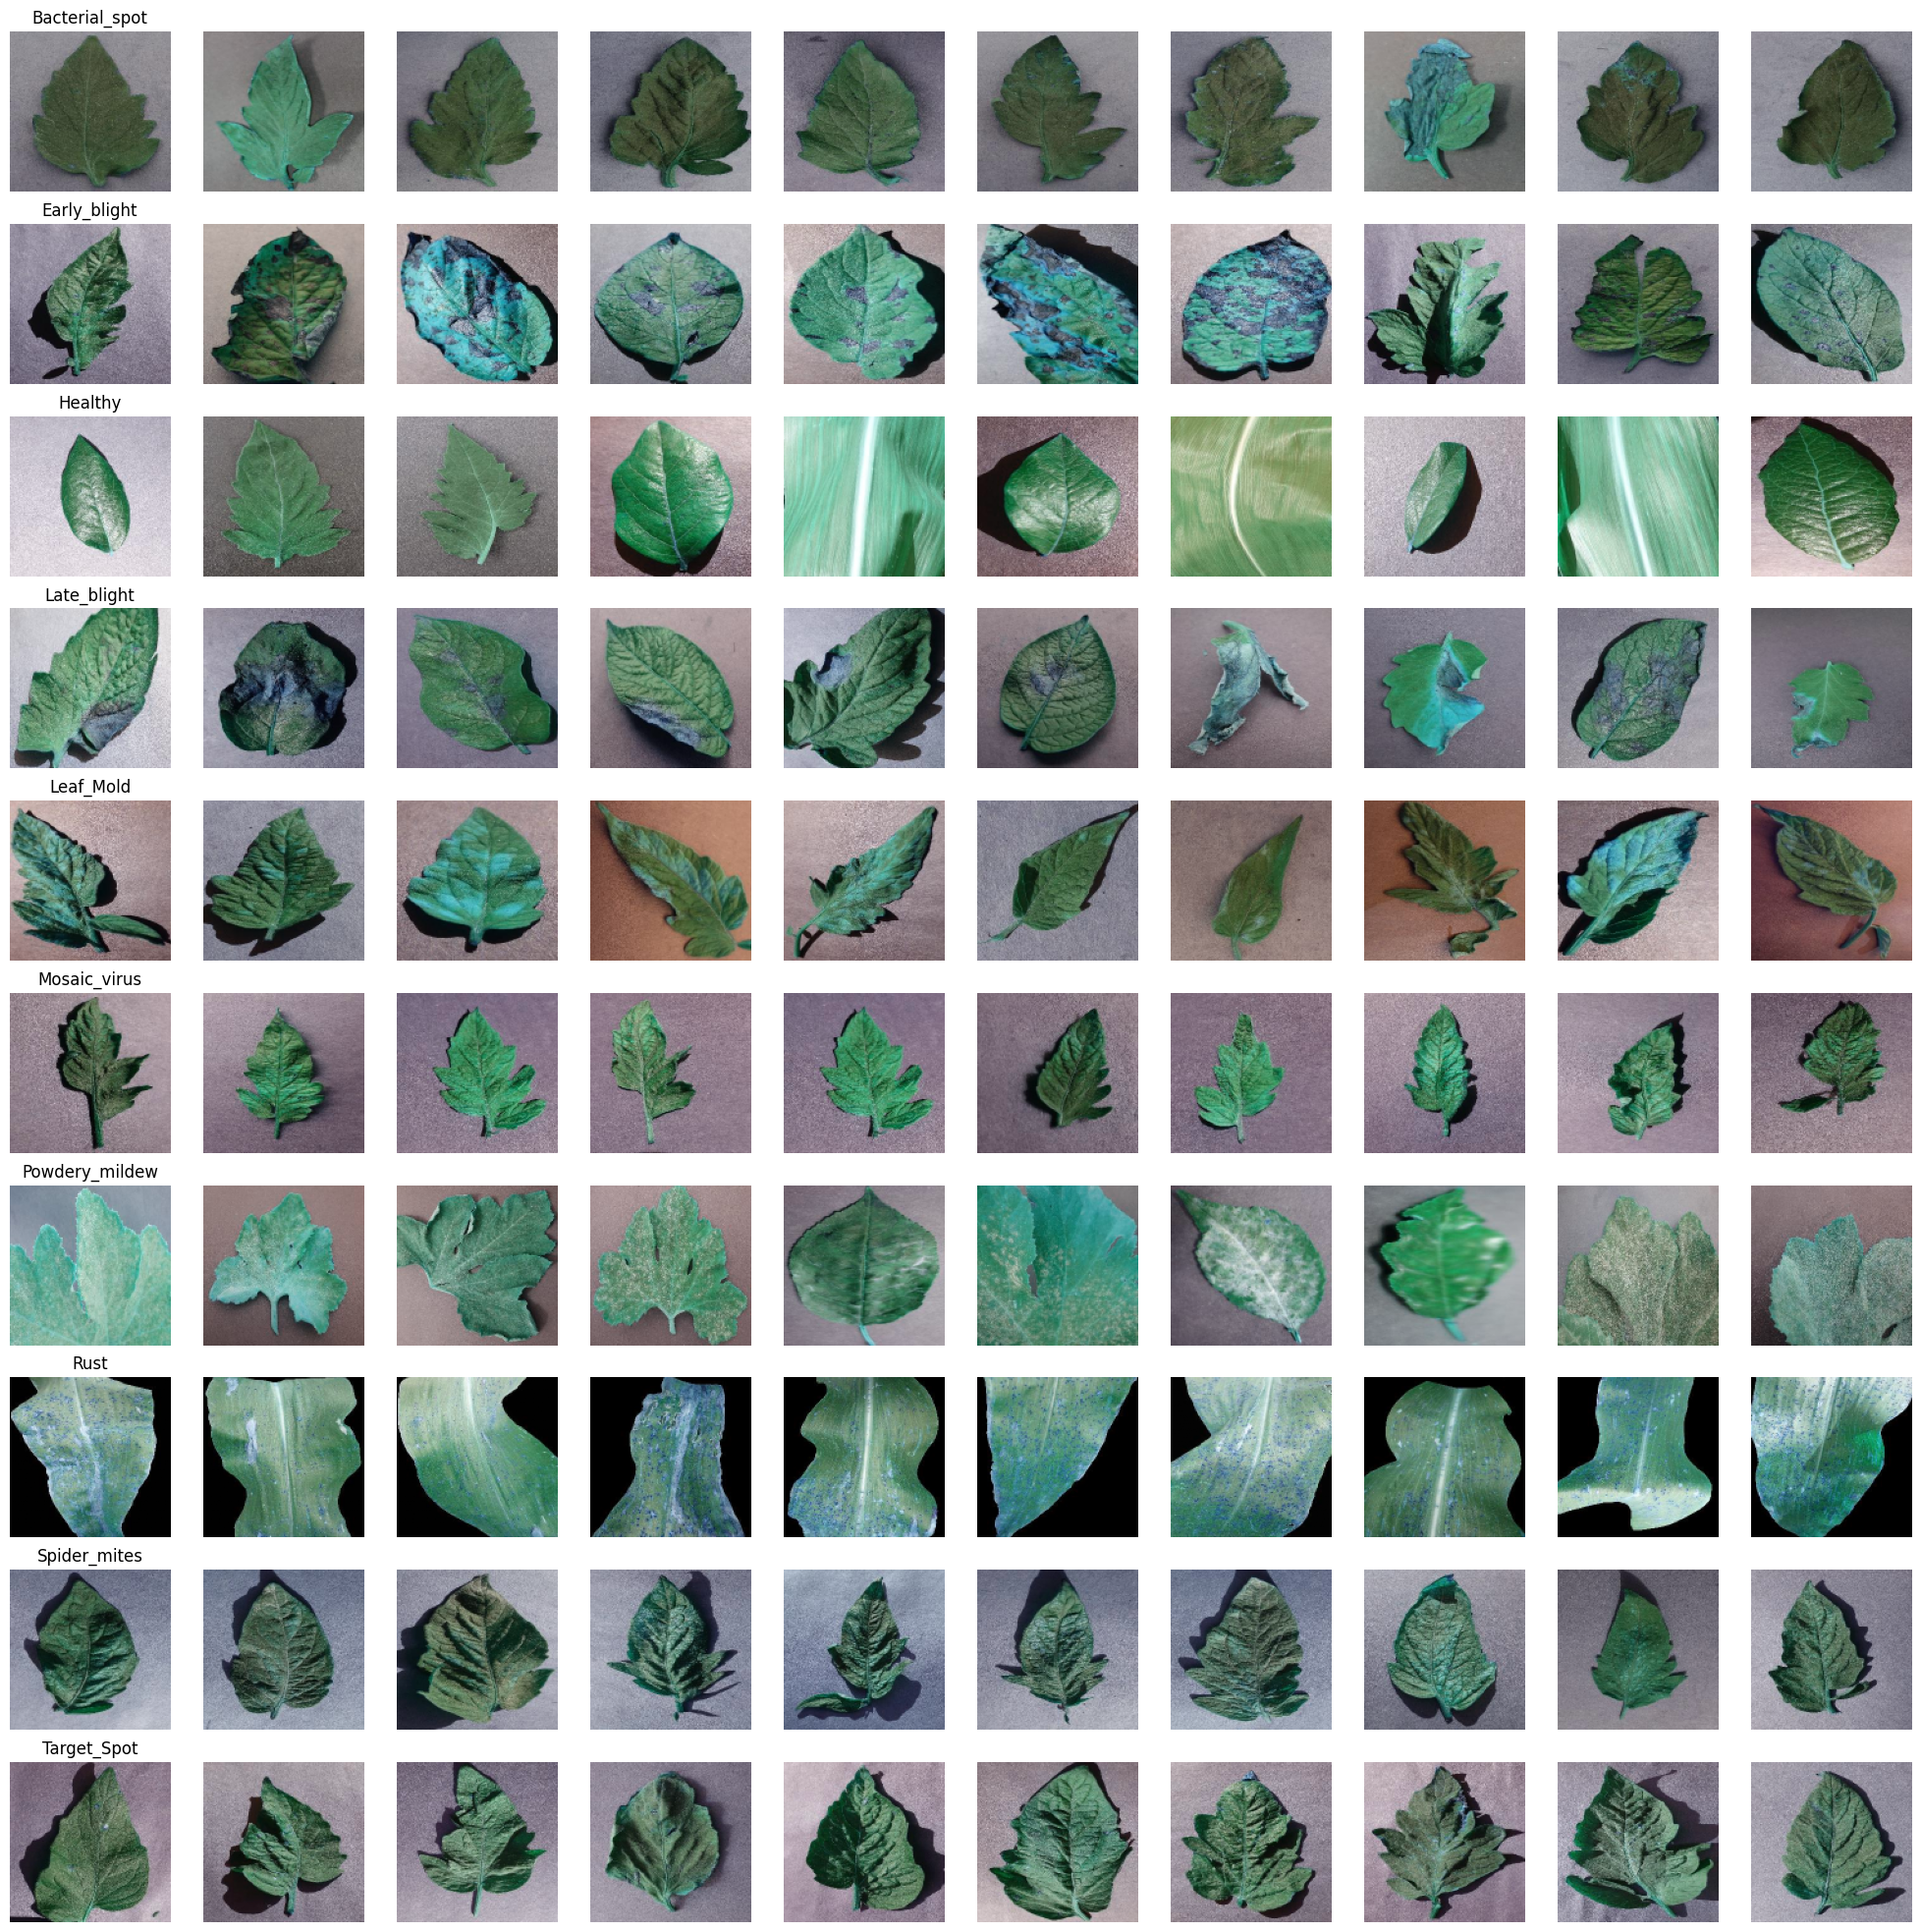

In [24]:
#Cette fonction roule jusqua ce quelle trouve une photo d'une classe spécifique puis retourne l'index.
def getRandomPicture(image_class, len_max, data):
    while True:
        idx = np.random.randint(len_max)
        idclass = data[idx]
        if idclass == image_class:
            return idx

# Définir les dimensions de la grille
rows = 10
cols = 10

labels = CATEGORIES
# Créer des figures vides pour le tableau
fig, axs = plt.subplots(rows, cols, figsize=(25, 25))

# Boucle sur les lignes de la grille
for i in range(rows):
    # Boucle sur les colonnes de la grille
    for j in range(cols):
        #Fonction définie plus haut pour aller chercher une image random d'une certaine emotion
        idx = getRandomPicture(i, X_train.shape[0], Y_train)
        
        # Choisir un indice aléatoire pour un échantillon
        # Afficher l'image à l'emplacement courant de la grille
        axs[i, j].imshow(X_train[idx])
        axs[i, j].axis('off')
        
    #Afficher le titre de chaque emotions
    axs[i, 0].set_title(labels[i])

# Distribution du data
Est-ce que notre ensemble de données est équilibré ?


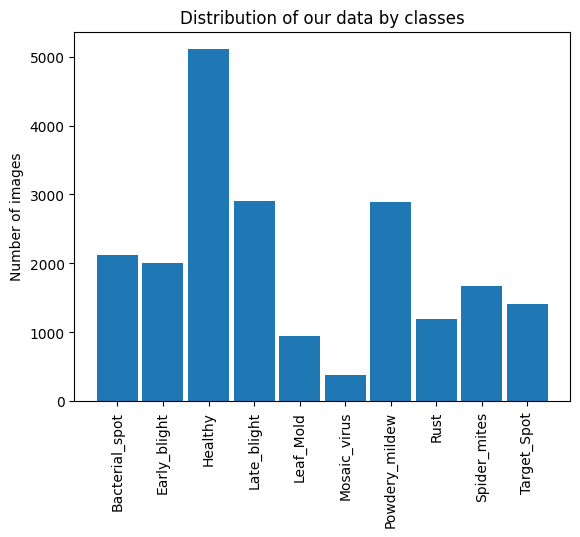

In [25]:
labels = CATEGORIES
counter = Counter(Y)

# Sort by class label
sorted_items = sorted(counter.items())

# Separate labels and counts
labels, counts = zip(*sorted_items)

# Create bar chart
plt.bar(labels, counts, tick_label=CATEGORIES, align='center',width=0.9)

plt.ylabel("Number of images")
plt.xticks(rotation='vertical')
plt.title("Distribution of our data by classes")
plt.show()


## Create model

In [27]:
def createModelResnet9(): #This is the architecture of a ResNet9 model
    nb_classes = 10
    model = Sequential()
    # --------------------------------------------
    model.add(Input(shape = X_train[0].shape))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(strides=4, pool_size=(2,2), padding='same'))

    model.add(Flatten())

    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'] )
    
    model.summary()
    
    return model

model = createModelResnet9()
callbacks_list = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0

# Train model

Epoch 1/20
722/722 [==============================] - 102s 139ms/step - loss: 0.9826 - accuracy: 0.6639 - val_loss: 6.7805 - val_accuracy: 0.2334
Epoch 2/20
722/722 [==============================] - 96s 132ms/step - loss: 0.5690 - accuracy: 0.8079 - val_loss: 6.8991 - val_accuracy: 0.3487
Epoch 3/20
722/722 [==============================] - 96s 133ms/step - loss: 0.4446 - accuracy: 0.8474 - val_loss: 0.7261 - val_accuracy: 0.7831
Epoch 4/20
722/722 [==============================] - 96s 132ms/step - loss: 0.3634 - accuracy: 0.8778 - val_loss: 1.5788 - val_accuracy: 0.6894
Epoch 5/20
722/722 [==============================] - 96s 133ms/step - loss: 0.3161 - accuracy: 0.8949 - val_loss: 0.9198 - val_accuracy: 0.7621
Epoch 6/20
722/722 [==============================] - 96s 132ms/step - loss: 0.2931 - accuracy: 0.9033 - val_loss: 0.7236 - val_accuracy: 0.7915
Epoch 7/20
722/722 [==============================] - 96s 132ms/step - loss: 0.2574 - accuracy: 0.9163 - val_loss: 0.6856 - val_a

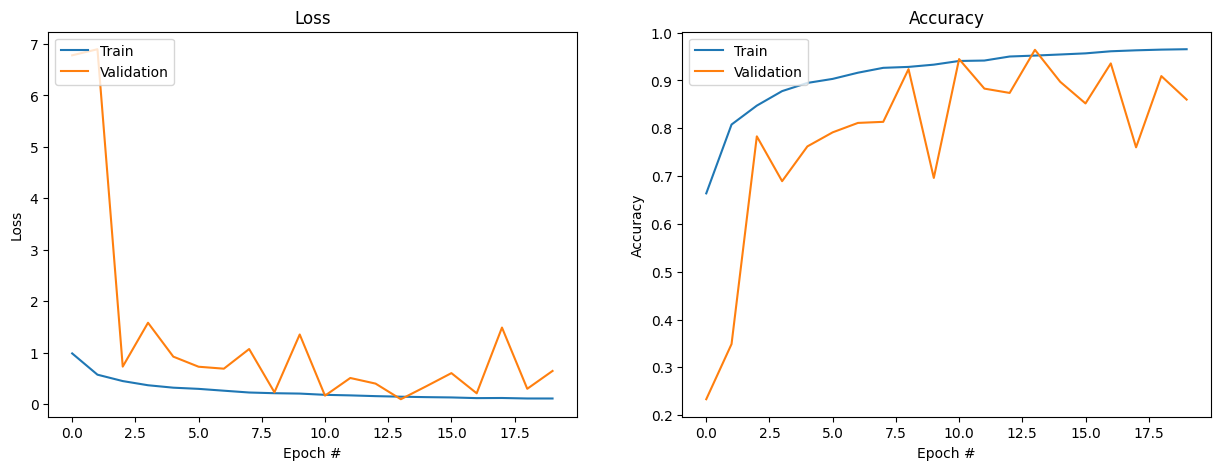

In [28]:
# General training parameters
nb_epoch    = 20
batch_size  = 48

#Data Augmentation, using ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=40,shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15)
train_generator = train_gen.flow(X_train, ytrain, batch_size=batch_size)



#fitting the model 
hist = model.fit(train_generator,
                      validation_data = (X_val, yval),
                      batch_size = batch_size, 
                      epochs = nb_epoch,
                      verbose = 1,
                      shuffle = True
                    )

fix, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.arange(0, nb_epoch), hist.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, nb_epoch), hist.history["val_loss"], label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Validation"],loc="upper left")

axes[1].plot(np.arange(0, nb_epoch), hist.history["accuracy"], label="train_acc")
axes[1].plot(np.arange(0, nb_epoch), hist.history["val_accuracy"], label="val_acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"], loc="upper left")
plt.show()

# ModelPlantPal01 graph
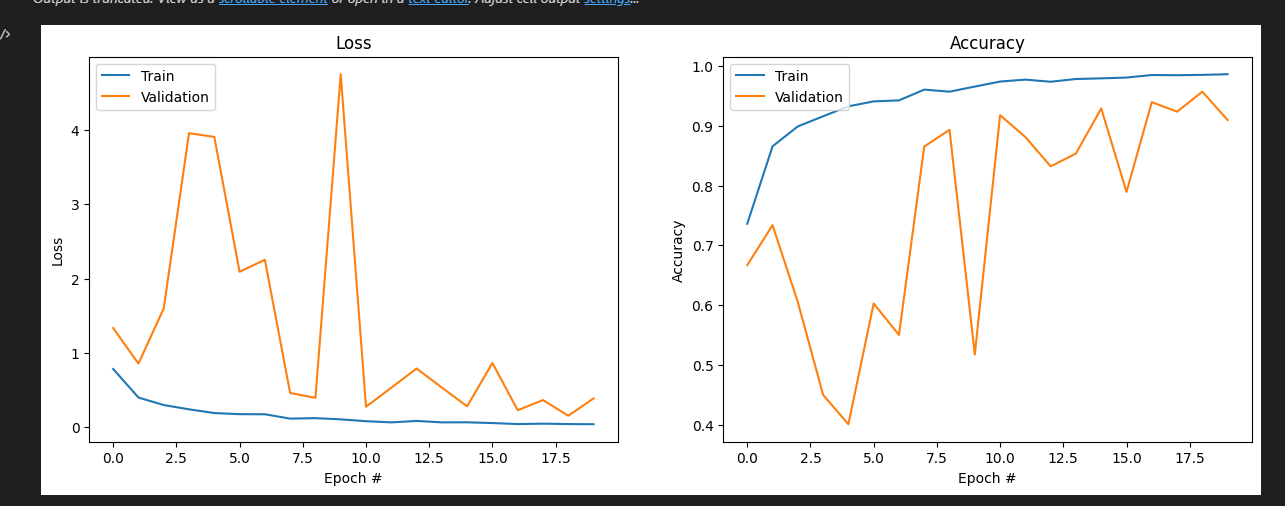

## FineTune Model

Currently fine-tuning a simple VGG19 model to get initial results

In [5]:
# One-hot encode the labels
ytrain = utils.to_categorical(Y_train)
yval   = utils.to_categorical(Y_val)
ytest  = utils.to_categorical(Y_test)

inp = Input(shape = X_train[0].shape, name="input")

img_pre = preprocess_input(inp)

vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))

#Only set the last 6 layers to be trainable.
for layer in vgg_model.layers[:-2]:
    layer.trainable = False

for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.output_shape, "trainable : ", layer.trainable)

flat = GlobalAveragePooling2D(name="GAV")(vgg_model(img_pre))
dense1 = Dense(64, activation="relu")(flat)
drop1 = Dropout(0.5)(dense1)

# Output layer
dense2 = Dense(10, activation="softmax", name="output")(drop1)
model = Model(inp, dense2)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
0 input_1 [(None, 224, 224, 3)] trainable :  False
1 block1_conv1 (None, 224, 224, 64) trainable :  False
2 block1_conv2 (None, 224, 224, 64) trainable :  False
3 block1_pool (None, 112, 112, 64) trainable :  False
4 block2_conv1 (None, 112, 112, 128) trainable :  False
5 block2_conv2 (None, 112, 112, 128) trainable :  False
6 block2_pool (None, 56, 56, 128) trainable :  False
7 block3_conv1 (None, 56, 56, 256) trainable :  False
8 block3_conv2 (None, 56, 56, 256) trainable :  False
9 block3_conv3 (None, 56, 56, 256) trainable :  False
10 block3_conv4 (None, 56, 56, 256) trainable :  False
11 block3_pool (None, 28, 28, 256) trainable :  False
12 block4_conv1 (None, 28, 28, 512) trainable :  False
13 block4_conv2 (None, 28, 28, 512) trainable :  False
14 block4_conv3 (None, 28, 28, 512) trainable :  False
15 block4_conv4 (None, 28, 28, 512) trainable :  False
16 block4_pool (None, 14, 14, 512) trainable :  False
17 block5_

## Train the model

Epoch 1/10
375/375 [==============================] - 152s 394ms/step - loss: 2.2752 - accuracy: 0.2093 - val_loss: 2.2233 - val_accuracy: 0.2051
Epoch 2/10
375/375 [==============================] - 139s 369ms/step - loss: 2.1983 - accuracy: 0.2140 - val_loss: 2.1888 - val_accuracy: 0.2051
Epoch 3/10
375/375 [==============================] - 120s 318ms/step - loss: 2.1738 - accuracy: 0.2140 - val_loss: 2.1758 - val_accuracy: 0.2051
Epoch 4/10
375/375 [==============================] - 119s 318ms/step - loss: 13363.2471 - accuracy: 0.2052 - val_loss: 2.1708 - val_accuracy: 0.2051
Epoch 5/10
375/375 [==============================] - 120s 319ms/step - loss: 2.1907 - accuracy: 0.2140 - val_loss: 2.1689 - val_accuracy: 0.2051
Epoch 6/10
375/375 [==============================] - 120s 320ms/step - loss: 2.1589 - accuracy: 0.2140 - val_loss: 2.1681 - val_accuracy: 0.2051
Epoch 7/10
375/375 [==============================] - 121s 322ms/step - loss: 2.1581 - accuracy: 0.2140 - val_loss: 2.16

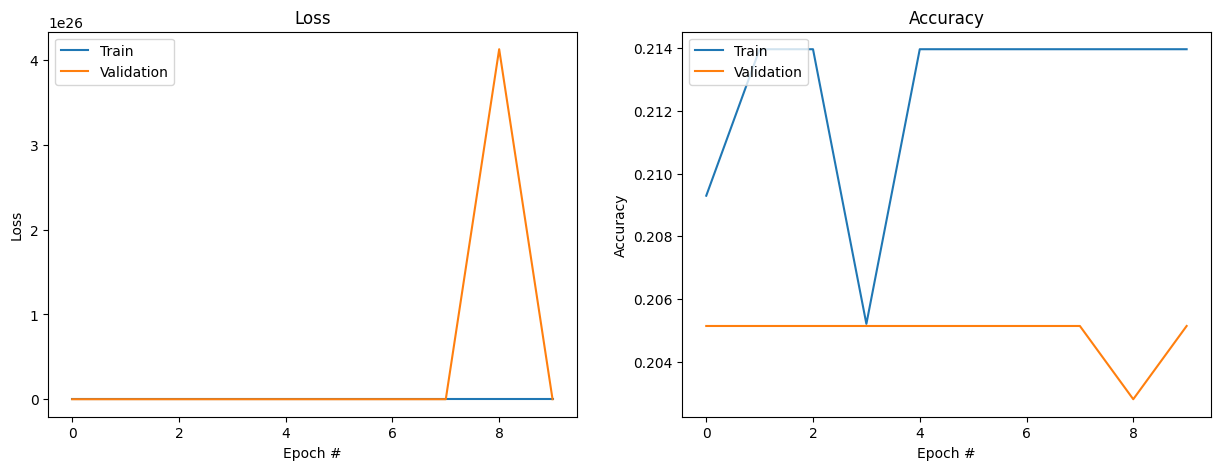

In [6]:
nb_epochs = 10
batch_size = 32

#Using ImageDataGenerator to augment the data
train_gen = ImageDataGenerator(rotation_range=40,shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15)
train_generator = train_gen.flow(X_train, ytrain, batch_size=batch_size)

model_data = model.fit(train_generator, validation_data=(X_val, yval), epochs=nb_epochs, batch_size=batch_size, verbose=1, shuffle=True)

# Plot the training and validation loss + accuracy
fix, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.arange(0, nb_epochs), model_data.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, nb_epochs), model_data.history["val_loss"], label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Validation"],loc="upper left")

axes[1].plot(np.arange(0, nb_epochs), model_data.history["accuracy"], label="train_acc")
axes[1].plot(np.arange(0, nb_epochs), model_data.history["val_accuracy"], label="val_acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"], loc="upper left")
plt.show()

# FineTune resnet9 ?

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 output (Dense)              (None, 10)                204810    
                                                                 
Total params: 4,254,381
Trainable params: 4,212,358
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/10
452/452 [==============================] - 173s 370ms/step - loss: 0.5369 - accuracy: 0.8668 - val_loss: 62.7741 - val_accuracy: 0.4929
Epoch 2/10
452/452 [=========

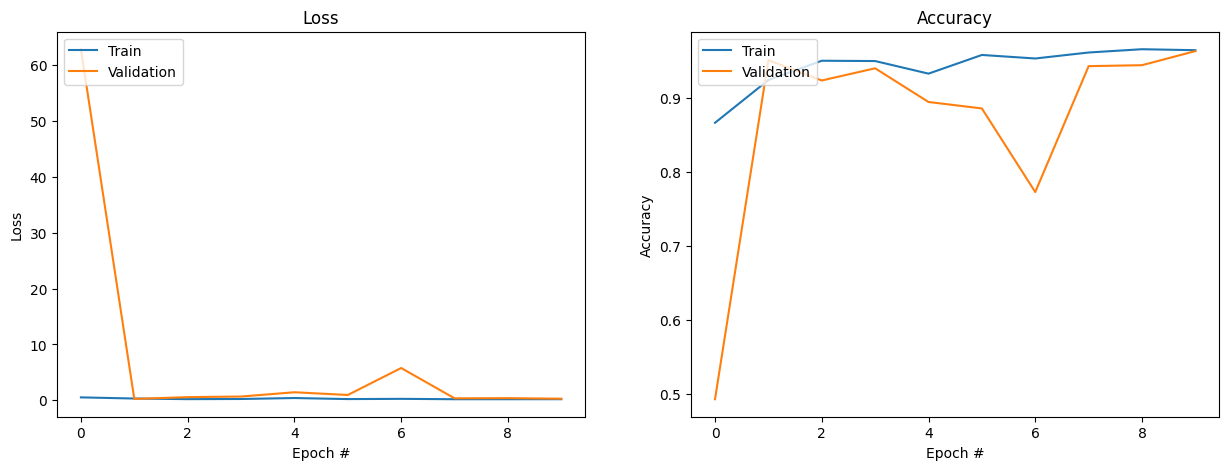

In [7]:
from tensorflow.keras.applications import EfficientNetB0

inp = Input(shape = X_train[0].shape, name="input")


efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128,3))

# Output layer
flat = Flatten()(efficient_net(inp))
dense = Dense(10, activation="softmax", name="output")(flat)
modelEffNet = Model(inp, dense)
modelEffNet.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
modelEffNet.summary()

nb_epochs = 10
batch_size = 32


#Using ImageDataGenerator to augment the data
train_gen = ImageDataGenerator(rotation_range=40,shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15)
train_generator = train_gen.flow(X_train, ytrain, batch_size=batch_size)

model_data = modelEffNet.fit(train_generator, validation_data=(X_val, yval), epochs=nb_epochs, batch_size=batch_size, verbose=1, shuffle=True)
fix, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.arange(0, nb_epochs), model_data.history["loss"], label="train_loss")
axes[0].plot(np.arange(0, nb_epochs), model_data.history["val_loss"], label="val_loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch #")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Validation"],loc="upper left")

axes[1].plot(np.arange(0, nb_epochs), model_data.history["accuracy"], label="train_acc")
axes[1].plot(np.arange(0, nb_epochs), model_data.history["val_accuracy"], label="val_acc")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch #")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"], loc="upper left")
plt.show()

## Evaluate our model

97/97 [==============================] - 7s 74ms/step
Report de classification
                precision    recall  f1-score   support

Bacterial_spot       1.00      0.98      0.99      2127
  Early_blight       0.97      0.98      0.97      2000
       Healthy       0.97      1.00      0.98      5108
   Late_blight       0.99      0.97      0.98      2909
     Leaf_Mold       1.00      0.83      0.91       952
  Mosaic_virus       0.81      1.00      0.90       373
Powdery_mildew       1.00      0.99      0.99      2887
          Rust       0.98      1.00      0.99      1192
  Spider_mites       0.94      0.92      0.93      1676
   Target_Spot       0.94      0.93      0.94      1404

      accuracy                           0.97     20628
     macro avg       0.96      0.96      0.96     20628
  weighted avg       0.97      0.97      0.97     20628

FER MLP test accuracy - last model: 96.96%
FER MLP test error    - last model: 3.04%
Taux de classification sur les 3 ensembles
+-----

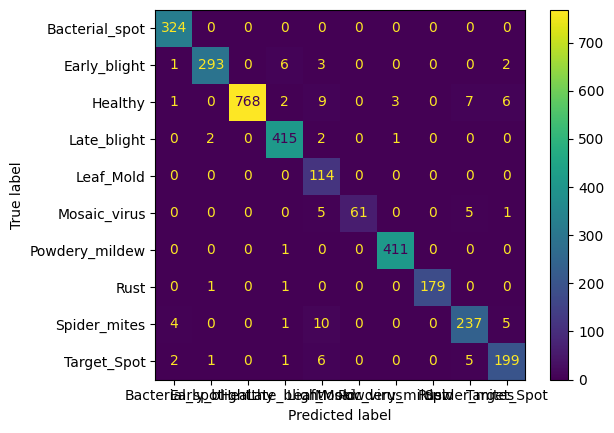

In [11]:
model = modelEffNet
labels = CATEGORIES

scoresTrain = model.evaluate(X_train, ytrain, verbose=0)
ypredtrain = model.predict(X_train)

scoresVal = model.evaluate(X_val, yval, verbose=0)
ypredval = model.predict(X_val)

scoresTest = model.evaluate(X_test, ytest, verbose=0)
ypredtest = model.predict(X_test)

ytruegenerals = np.concatenate((ytrain.argmax(axis=1), yval.argmax(axis=1), ytest.argmax(axis=1)), axis=0)
ypredgenerals = np.concatenate((ypredtrain.argmax(axis=1), ypredval.argmax(axis=1), ypredtest.argmax(axis=1)), axis=0)

print("Report de classification")
print(classification_report(ytruegenerals,ypredgenerals, target_names=labels))

print("FER MLP test accuracy - last model: %.2f%%" % (scoresTest[1]*100))
print("FER MLP test error    - last model: %.2f%%" % (100-scoresTest[1]*100))

#Tableau de comparaison d'accuracy
print("Taux de classification sur les 3 ensembles")
table = PrettyTable(["Ensemble", "Accuracy (%)"])
table.add_row(["App", round(scoresTrain[1]*100,2)])
table.add_row(["Val", round(scoresVal[1]*100,2)])
table.add_row(["Test", round(scoresTest[1]*100,2)])
print(table)

confusion_matrix = metrics.confusion_matrix(ypredtest.argmax(axis=1), ytest.argmax(axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =labels)
cm_display.plot()
plt.show()

# Save the model

In [10]:
#modelEffNet.save("../../AIModels/modelPlantPalLatest")
modelEffNet.save_weights("../../AIModels/modelPlantPalLatestWeights")

# Load model

In [5]:
inp = Input(shape = X_train[0].shape, name="input")


efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128,128,3))

# Output layer
flat = Flatten()(efficient_net(inp))
dense = Dense(10, activation="softmax", name="output")(flat)
newModel = Model(inp, dense)
newModel.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
newModel.summary()

newModel.load_weights("../../AIModels/modelPlantPalLatestWeights")
#loss, acc = newModel.evaluate(X_test, ytest, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

NameError: name 'X_train' is not defined

In [2]:
def getIndex(oneHotEncodedTab):
    index = 0
    for i in range(len(oneHotEncodedTab)):
        if oneHotEncodedTab[i] == 1:
            index = i
    return index

size =128
categories = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Powdery_mildew', 'Rust', 'Spider_mites', 'Target_Spot']

loaded_model = newModel

images = []

for image in os.listdir("testData"):
    img_array = cv2.imread(os.path.join("testData", image))
    img_resized = cv2.resize(img_array, (size, size))
    images.append(img_resized)

images = np.array(images)
pred = loaded_model.predict(images)

for i in range(len(images)):
    print(pred[i])
    max = np.argmax(pred[i])
    confidence = pred[i][max]
    print("Image ",i,", Predicting : ", categories[max], ", with confidence : ", confidence)
print("done !")

NameError: name 'newModel' is not defined

## Test and load model
